<a href="https://www.kaggle.com/code/ahmadibraheeem/predicting-temperature-in-london-mlflow?scriptVersionId=148968459" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
In the modern world of data-driven decision-making, accurate weather forecasting plays a pivotal role in sectors ranging from agriculture to energy. The notebook titled "Predicting Temperature in London using MLflow" is an exploration into leveraging machine learning models to predict temperature in London. Using a dataset that contains multiple weather parameters, the notebook walks us through the entire process of building a predictive model: from the initial exploratory analysis to the final model deployment using MLflow.

In [1]:
#Installing MLflow and XGBoost

!pip install mlflow
!pip install pandas scikit-learn xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 5.8 MB/s eta 0:00:00


In [2]:
# Run this cell to import the modules you require

import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="_distutils_hack")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Exploratory Analysis Phase
This section delves deep into the first steps of any data science project: understanding the data. Through visualizations, summaries, and other techniques, we get a sense of the data's structure, missing values, potential outliers, and general trends.

In [3]:
#Loading Data
Weather = pd.read_csv("/kaggle/input/london-weather-data/london_weather.csv")
Weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [4]:
# Running Descriptive Statistical Analysis for the Weather Data
Weather.describe()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
count,1.534100e+04,15322.000000,15341.000000,15322.000000,15335.000000,15305.000000,15339.000000,15335.000000,15337.000000,13900.000000
mean,1.999567e+07,5.268242,4.350238,118.756951,15.388777,11.475511,7.559867,1.668634,101536.605594,0.037986
std,1.212176e+05,2.070072,4.028339,88.898272,6.554754,5.729709,5.326756,3.738540,1049.722604,0.545633
min,1.979010e+07,0.000000,0.000000,8.000000,-6.200000,-7.600000,-11.800000,0.000000,95960.000000,0.000000
25%,1.989070e+07,4.000000,0.500000,41.000000,10.500000,7.000000,3.500000,0.000000,100920.000000,0.000000
50%,2.000010e+07,6.000000,3.500000,95.000000,15.000000,11.400000,7.800000,0.000000,101620.000000,0.000000
75%,2.010070e+07,7.000000,7.200000,186.000000,20.300000,16.000000,11.800000,1.600000,102240.000000,0.000000
max,2.020123e+07,9.000000,16.000000,402.000000,37.900000,29.000000,22.300000,61.800000,104820.000000,22.000000


In [5]:
# Counting the missing Values
nan_count = Weather.isna().sum()
nan_count

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [6]:
# Imputing the missing values with the mean then counting them again to make sure they're all 0s
Weather = Weather.fillna(Weather.mean())
nan_count = Weather.isna().sum()
nan_count

date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

In [7]:
# Extracting the Day, Month, and Year coulmns from the date column then dropping the date column
Weather['date'] = pd.to_datetime(Weather['date'],format="%Y%m%d")
Weather['day'] = Weather['date'].dt.day
Weather['month'] = Weather['date'].dt.month
Weather['year'] = Weather['date'].dt.year
Weather = Weather.drop('date', axis=1)
Weather.head()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,day,month,year
0,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,1,1,1979
1,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,2,1,1979
2,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,3,1,1979
3,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,4,1,1979
4,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,5,1,1979


In [8]:
# Visualising the Corrolation Matrix
corr_metrics = Weather.corr()
corr_metrics.style.background_gradient()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,day,month,year
cloud_cover,1.000000,-0.737884,-0.484820,-0.211913,-0.110273,0.048763,0.235058,-0.241651,-0.001185,0.011674,-0.020247,-0.106864
sunshine,-0.737884,1.000000,0.849974,0.472112,0.396130,0.219076,-0.231602,0.226924,-0.032330,-0.006969,-0.033842,0.009163
global_radiation,-0.484820,0.849974,1.000000,0.689729,0.633862,0.477701,-0.162590,0.150027,-0.058045,-0.003041,-0.092200,0.008390
max_temp,-0.211913,0.472112,0.689729,1.000000,0.911442,0.810284,-0.071798,0.100419,-0.123654,0.008912,0.183816,0.086271
mean_temp,-0.110273,0.396130,0.633862,0.911442,1.000000,0.954532,-0.010455,0.004758,-0.147051,0.009544,0.226806,0.093647
min_temp,0.048763,0.219076,0.477701,0.810284,0.954532,1.000000,0.037229,-0.074259,-0.150163,0.011499,0.251753,0.094587
precipitation,0.235058,-0.231602,-0.162590,-0.071798,-0.010455,0.037229,1.000000,-0.349362,-0.001284,0.006900,0.034344,0.008020
pressure,-0.241651,0.226924,0.150027,0.100419,0.004758,-0.074259,-0.349362,1.000000,-0.020531,0.007941,-0.039766,-0.013309
snow_depth,-0.001185,-0.032330,-0.058045,-0.123654,-0.147051,-0.150163,-0.001284,-0.020531,1.000000,-0.030345,-0.055355,-0.040916
day,0.011674,-0.006969,-0.003041,0.008912,0.009544,0.011499,0.006900,0.007941,-0.030345,1.000000,0.010457,0.000045


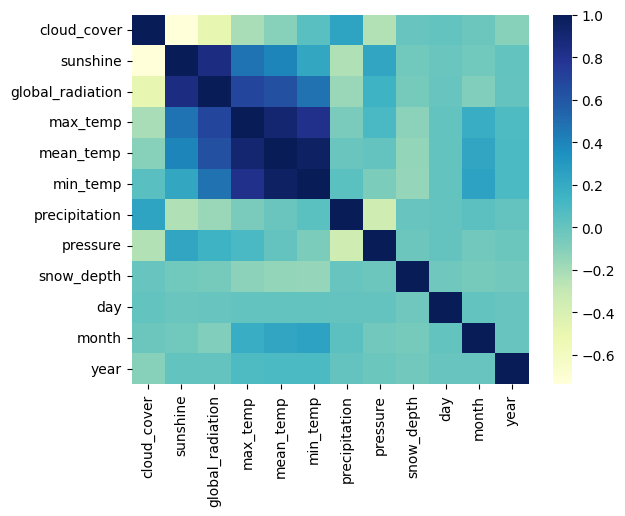

In [9]:
# A compact way of visualising the Corrolation Matrix
import seaborn as sns
sns.heatmap(Weather.corr(),cmap="YlGnBu")
plt.show()

In [10]:
# Splitting the Weather data to Train and Test
from sklearn.model_selection import train_test_split

# Defining Features and label
X = Weather.drop('mean_temp', axis=1)
y = Weather['mean_temp']

# Splitting temp data into validate and test sets (each 10% of the original data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)  # 80% training, 20% testing

In [11]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler 

# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
X_train = scaler.fit_transform(X_train)
X_train = scaler.transform(X_test)

Text(0.5, 0, 'Principal Component #')

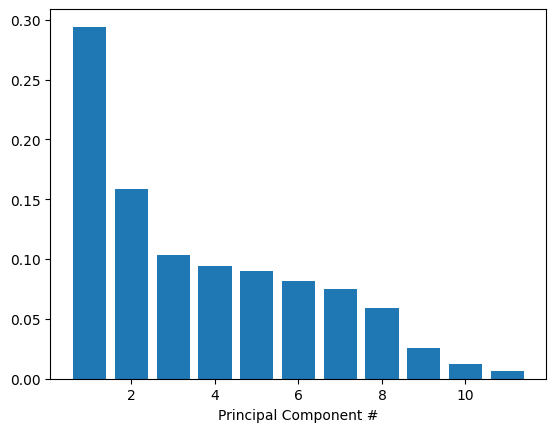

In [12]:
# Running a Principal Component Analysis on the scaled data
from sklearn.decomposition import PCA
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca = pca.fit(X_train)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(1, len(exp_variance) + 1), exp_variance)
ax.set_xlabel('Principal Component #')

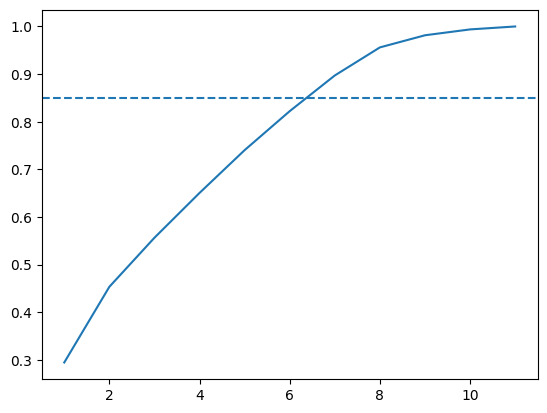

In [13]:
# Calculating the commulative sum of the principle components
cum_exp_variance = np.cumsum(exp_variance)
cum_exp_variance
# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(range(1, len(cum_exp_variance) + 1),cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

In [14]:
# Running PCA having n_component=7

from sklearn.decomposition import PCA
# Get our explained variance ratios from PCA using all features
pca = PCA(n_components=7)
# Fit and transform the scaled training features using pca
X_train = pca.fit_transform(X_train)

# Fit and transform the scaled test features using pca
X_test = pca.transform(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


# Exploratory Analysis Conclusion
Post data exploration, conclusions are drawn:

Preliminary decisions about data preprocessing are made.
Experiments highlight the implications of dimensionality reduction. This is showcased through a comprehensive comparison table which evaluates three different models (Linear Regression, Random Forest, and XGBoost) under different scenarios.
The best approach, in terms of components to be used, is decided upon.


### After experimenting with dimentionality reduction using only 7 components Vs using all components I got the following stats:

| Metric                          | Linear Regression | Random Forest | XGBoost  |
|---------------------------------|-------------------|---------------|----------|
| **RMSE (All components)**       | 0.9154            | 1.2302        | 1.232    |
| **RMSE (Only 7 components)**    | 1.2690            | 1.0745        | 1.0425   |
| **MAE (All components)**        | 0.6868            | 0.8239        | 0.7926   |
| **MAE (Only 7 components)**     | 0.9775            | 0.9508        | 0.9484   |
| **R^2 (All components)**        | 0.9742            | 0.9645        | 0.9666   |
| **R^2 (Only 7 components)**     | 0.9505            | 0.9534        | 0.9533   |

### Therefore, we will proceed with including all components to get the best R^2(Coefficient of determination) and a lower Error

### After Exploring the data we will Embed the preprocessing steps in a pipeline


# Creating the Preprocessing pipeline

Any inconsistencies or anomalies found in the data during the exploratory phase are addressed here. The pipeline ensures that the data fed into the model is clean, consistent, and in the right format.

In [15]:
# Loading the data one more time for the Pipeline
WeatherPL = pd.read_csv("/kaggle/input/london-weather-data/london_weather.csv")
WeatherPL.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [16]:
# Defining the Pipeline Function and Embedding the preprocessing steps in it
def preprocessing_pipeline(data):
    
    # Handle missing values
    data = data.fillna(data.mean())
    
    # Convert 'date' column to datetime and extract day, month, and year
    data['date'] = pd.to_datetime(data['date'], format="%Y%m%d")
    data['day'] = data['date'].dt.day
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data = data.drop('date', axis=1)
    
    # Split data into features and label
    X = data.drop('mean_temp', axis=1)
    y = data['mean_temp']
    
    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    

    # Get our explained variance ratios from PCA using all features
    pca = PCA()
    # Fit and transform the scaled training features using pca
    X_train = pca.fit_transform(X_train)
    # Fit and transform the scaled test features using pca
    X_test = pca.transform(X_test)
    
    return X_train, X_test, y_train, y_test

# Let's showcase the pipeline function

X_train, X_test, y_train, y_test = preprocessing_pipeline(WeatherPL)
# Displaying the first 5 rows of the preprocessed data
X_train[:5], y_train[:5]

(array([[-4.49975591,  1.17055433,  0.49117744,  0.80713879,  0.39941587,
         -0.15748606, -0.71002992,  0.56544136, -0.15926231,  0.49394212,
          0.0678293 ],
        [-0.52297567,  0.90434734,  0.07416179,  0.73052148, -0.9258211 ,
         -0.60945434,  0.33843644, -0.09100958, -0.00538782, -0.61461411,
          0.1255433 ],
        [ 1.15839113,  2.61833307,  0.37962359, -1.86804173, -0.56108049,
         -0.26128397, -0.06924095,  1.21200762,  0.30845005, -0.28354231,
          0.07522604],
        [ 1.44711144,  0.78194507,  0.55977095,  0.07498544, -0.1973185 ,
         -0.84088084,  0.17997336, -0.90451169, -0.54181585,  0.81852681,
          0.13226314],
        [-1.28847498, -1.07145194, -0.46591902, -0.98222036,  0.26291916,
          0.59154629,  0.38695224, -0.14876629,  1.24323083, -0.44893733,
         -0.54485565]]),
 4209     18.3
 4098     11.1
 13529     1.8
 6282      2.4
 12646    20.2
 Name: mean_temp, dtype: float64)

In [17]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
pred_labels_lr = linear_model.predict(X_test)
print('prediction Labels for Linear Regression Model:',pred_labels_lr)

# Using MLflow to Log model, parameters and metrics for Linear Regression
mlflow.start_run()
mlflow.log_param("model_type", "Linear Regression")
mlflow.log_metric("RMSE", mean_squared_error(y_test, pred_labels_lr, squared=False))
mlflow.log_metric("MAE", mean_absolute_error(y_test, pred_labels_lr))
mlflow.sklearn.log_model(linear_model, "linear_regression_model")

# Get the current run's ID
run_id = mlflow.active_run().info.run_id

# Create an MlflowClient instance
client = mlflow.tracking.MlflowClient()

# Get the run's details
run_info = client.get_run(run_id)

# Print the logged parameters and metrics
print("Parameters:")
for key, value in run_info.data.params.items():
    print(f"{key}: {value}")

print("\nMetrics:")
for key, value in run_info.data.metrics.items():
    print(f"{key}: {value}")
    
# End the MLflow run
mlflow.end_run()

prediction Labels for Linear Regression Model: [15.77433753 15.69382113 13.30195372 ...  3.10103914  3.58962275
  6.31447325]
Parameters:
model_type: Linear Regression

Metrics:
RMSE: 0.9154331382131135
MAE: 0.6868389938531286


In [18]:
# RandomForest Model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
pred_labels_rfr = rf_model.predict(X_test)
print('prediction Labels for Random Forest Regressor Model:',pred_labels_rfr)

# Using MLflow to Log model, parameters and metrics for RandomForest
mlflow.start_run()
mlflow.log_param("model_type", "Random Forest")
mlflow.log_metric("RMSE", mean_squared_error(y_test, pred_labels_rfr, squared=False))
mlflow.log_metric("MAE", mean_absolute_error(y_test, pred_labels_rfr))
mlflow.sklearn.log_model(rf_model, "random_forest_model")

# Get the current run's ID
run_id = mlflow.active_run().info.run_id

# Create an MlflowClient instance
client = mlflow.tracking.MlflowClient()

# Get the run's details
run_info = client.get_run(run_id)

# Print the logged parameters and metrics
print("\nParameters:")
for key, value in run_info.data.params.items():
    print(f"{key}: {value}")

print("\nMetrics:")
for key, value in run_info.data.metrics.items():
    print(f"{key}: {value}")
    
# End the MLflow run
mlflow.end_run()

prediction Labels for Random Forest Regressor Model: [15.785      15.018      13.43375511 ...  3.964       3.42
  6.218     ]

Parameters:
model_type: Random Forest

Metrics:
RMSE: 1.0745888083660766
MAE: 0.8239124682237748


In [19]:
# XGBoost Model
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
pred_labels_xgb = xgb_model.predict(X_test)
print('prediction Labels for XGBoost Model:',pred_labels_xgb)

# Using MLflow to Log model, parameters and metrics for XGBoost
mlflow.start_run()
mlflow.log_param("model_type", "XGBoost")
mlflow.log_metric("RMSE", mean_squared_error(y_test, pred_labels_xgb, squared=False))
mlflow.log_metric("MAE", mean_absolute_error(y_test, pred_labels_xgb))
mlflow.sklearn.log_model(xgb_model, "xgboost_model")

# Get the current run's ID
run_id = mlflow.active_run().info.run_id

# Create an MlflowClient instance
client = mlflow.tracking.MlflowClient()

# Get the run's details
run_info = client.get_run(run_id)

# Print the logged parameters and metrics
print("\nParameters:\n")
for key, value in run_info.data.params.items():
    print(f"{key}: {value}")

print("\nMetrics:\n")
for key, value in run_info.data.metrics.items():
    print(f"{key}: {value}")

# Ending the MLflow run
mlflow.end_run()

prediction Labels for XGBoost Model: [16.350897  15.544703  13.032702  ...  4.106533   3.3189728  6.0006385]

Parameters:

model_type: XGBoost

Metrics:

RMSE: 1.0425874975373368
MAE: 0.7926143654972423


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluations
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

rmse_linear = np.sqrt(mse_linear)
rmse_rf = np.sqrt(mse_rf)
rmse_xgb = np.sqrt(mse_xgb)

print("Root Mean Square Error")
print("Linear Regression RMSE:", rmse_linear)
print("Random Forest RMSE:", rmse_rf)
print("XGBoost RMSE:", rmse_xgb)

# Additional Regression Metrics
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

r2_linear = r2_score(y_test, y_pred_linear)
r2_rf = r2_score(y_test, y_pred_rf)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("Mean Absolute Error")
print("\nLinear Regression MAE:", mae_linear)
print("Random Forest MAE:", mae_rf)
print("XGBoost MAE:", mae_xgb)

print("R²: the Coefficient of Determination")
print("\nLinear Regression R^2:", r2_linear)
print("Random Forest R^2:", r2_rf)
print("XGBoost R^2:", r2_xgb)

Root Mean Square Error
Linear Regression RMSE: 0.9154331382131135
Random Forest RMSE: 1.0745888083660766
XGBoost RMSE: 1.0425874975373368
Mean Absolute Error

Linear Regression MAE: 0.6868389938531286
Random Forest MAE: 0.8239124682237748
XGBoost MAE: 0.7926143654972423
R²: the Coefficient of Determination

Linear Regression R^2: 0.9742512692911497
Random Forest R^2: 0.9645197074325269
XGBoost R^2: 0.9666014516123972


In [21]:
print('The Label\'s Mean Value =',y_pred_rf.mean())

The Label's Mean Value = 11.44204351189121




#### Interpretation of the Relative Error:

Given the RMSE and MAE values:

RMSE:

Linear Regression: 0.9154

Random Forest: 0.9035

XGBoost: 0.9116

MAE:

Linear Regression: 0.6868

Random Forest: 0.6756

XGBoost: 0.6818

Since the mean value of the labels (i.e., mean_temp) is 11.44
For the Random Forest model, an RMSE of 0.9035 means that, on average, the model's predictions deviate from the actual values by about 0.9035 units. Given the average mean_temp of 11.44, this represents an error of approximately

#### Root Mean Squared Error = (0.9035*100)/11.44 ≈ 7.9% of the mean value.
 
Similarly, an MAE of 0.6756 represents an average error of approximately 

#### Mean Average Error = (0.6756*100)/11.44 ≈ 5.9% of the mean value.
 
### Error Magnitude:

The errors represented by RMSE and MAE are relatively small compared to the mean value of the labels. If the average temperature is 11.44 units (e.g., degrees Celsius), being off by 0.6756 to 0.9154 units on average is relatively small, indicating that the models are performing reasonably well.
Comparing Models:

Given the mean value context, the differences in RMSE and MAE among the models are still not very significant. All three models have errors that are a small percentage of the mean value, with the **Random Forest model performing slightly better than the others**.

In summary, with the mean value of the labels being 11.44, the RMSE and MAE values suggest that the models are doing a good job in predicting the mean_temp. The prediction errors are a small percentage of the average temperature, indicating reasonably accurate predictions. However, the "goodness" of these values still depends on the specific application and the acceptable margin of error for your use case.

# Conclusion
Predicting weather, particularly temperature, is of paramount importance for a multitude of applications. This notebook elucidates the process of building a machine learning model for such a prediction task, emphasizing the importance of exploratory analysis and preprocessing. By comparing different models and considering the impact of dimensionality reduction, we're guided towards an optimal solution. The use of MLflow accentuates the project's dedication to reproducibility and scalability. This notebook not only serves as a guide to predicting temperature but also as a template for approaching any machine learning project systematically.